In [1]:
%load_ext autoreload
%autoreload 2

# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [124]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torchmetrics
import numpy as np
import pandas as pd
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import matplotlib.pyplot as plt

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

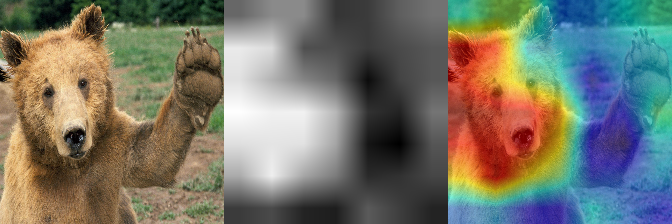

In [125]:
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer 
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.010518636554479599
The visualization of the pertubated image for the metric:


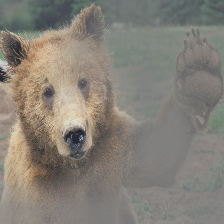

In [126]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|██████████| 64/64 [00:01<00:00, 38.49it/s]


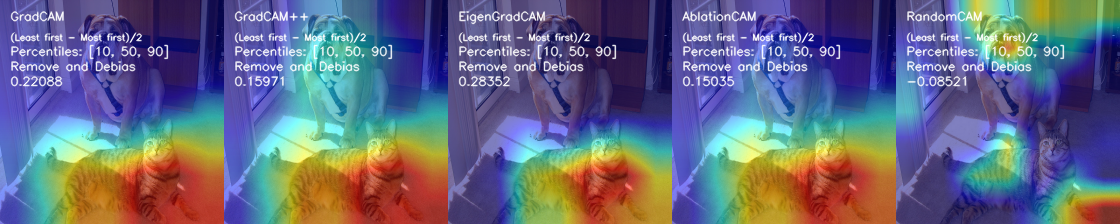

In [127]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, img, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, use_cuda=True)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, use_cuda=True))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, cat_and_dog, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [10]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of 
# them are compatible with the standard torchvision models
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
train_set, valid_set = random_split(train_set, [0.8, 0.2])
# You are expected to create the appropriate dataloaders to be used for training, testing and validation 
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
med_model = models.resnet50(pretrained=True)
med_model.fc = nn.Linear(2048, 8)
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/icb/mostafa.shahhosseini/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/icb/mostafa.shahhosseini/.medmnist/bloodmnist.npz


### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop 
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how 
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchmetrics.functional as f

# You are expected to save the models during training 
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None

def train(device='cuda', 
          model=None, 
          train_loader=None, 
          epochs=10, 
          learning_rate=0.001, 
          input_tensor=None, 
          targets=None, 
          image=None):
    images = {
        'gradcam':[],
        'gradcamplusplus':[],
        'EigenGradCAM':[],
        'AblationCAM':[],
        'RandomCAM':[],
    }
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()
    metrics = {
        "auroc":[],
        "acc":[],
        "mce":[],
        "dice":[],
        "f1":[],
        "perc":[],
        "rec":[],
        "spec":[]
    }
    loss_total = []
    for epoch in tqdm(range(epochs)):
        predictions = []
        truth_labels = []
        losses = []
        valid_losses = []
        accuracies = []
        for i, (data, target) in enumerate(tqdm(train_loader)): 
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)
            loss.backward()
            optimizer.step()
            predictions += [output.cpu()]
            truth_labels += [np.array(labels)]
        predictions = torch.cat(predictions)
        truth_labels = torch.tensor(np.concatenate(np.array(truth_labels)))
        metr = calculate_metrics(predictions, truth_labels.flatten())
        for key in metrics:
            metrics[key] += [metr[key]]
        loss_total += [np.mean(losses)]
        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader)): 
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred, target)
                valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]
        with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
            images['gradcam'] += [cam_image]
        with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
            images['gradcamplusplus'] += [cam_image]
            
        with EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
            images['EigenGradCAM'] += [cam_image]
            
        with AblationCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
            images['AblationCAM'] += [cam_image]
            
        with RandomCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
            images['RandomCAM'] += [cam_image]

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )
    metrics.update({'loss':loss_total})
    return model, images, metrics 

In [47]:
def test(device, model, data_loader, mean=0.5432, std=0.2731, input_tensor=None, targets=None, img=None):
    model.eval()
    preds = []
    pred_list = []
    # The target for the CAM is the Bear category.
    # As usual for classication, the target is the logit output
    # before softmax, for that category.
    # targets = [ClassifierOutputTarget(295)]
    target_layers = [model.layer4]
    correct=0
    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            image = image.to(device)
            target = target

            output = model(image).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"cam testing")
    images = {
        'gradcam':[],
        'gradcamplusplus':[],
        'EigenGradCAM':[],
        'AblationCAM':[],
        'RandomCAM':[],
    }
    target_layers = [model.layer4]
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        images['gradcam'] += [cam_image]
    with GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        images['gradcamplusplus'] += [cam_image]
    with EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        images['EigenGradCAM'] += [cam_image]
    with AblationCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        images['AblationCAM'] += [cam_image]
    with RandomCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        images['RandomCAM'] += [cam_image]
    return np.concatenate(pred_list), images

In [30]:
def calculate_metrics(preds, targets):
    auroc = f.auroc(preds, targets.flatten(), task='multiclass', num_classes=8)
    acc = f.classification.accuracy(torch.argmax(preds, dim=1).flatten(), targets.flatten(), average='macro', task='multiclass', num_classes=8)
    mce = f.classification.multiclass_calibration_error(preds, targets, n_bins=2, norm='l2', num_classes=8)
    dice = f.dice(preds, targets, average='macro',  num_classes=8)
    f1 = f.f1_score(preds, targets, task="multiclass", num_classes=8)
    perc = f.precision(preds, targets, task="multiclass", average='macro', num_classes=8)
    rec = f.recall(preds, targets, task="multiclass", average='macro', num_classes=8)
    spec = f.specificity(preds, targets, task="multiclass", average='macro', num_classes=8)
    return dict(
                auroc=auroc,
                acc=acc,
                mce=mce,
                dice=dice,
                f1=f1,
                perc=perc,
                rec=rec,
                spec=spec)

In [34]:
batch = list(iter(train_loader))[0]
batch_image, batch_targets = batch
image = batch_image[0]
target = batch_targets[0]
image = image.permute(2, 1, 0).numpy()
targets = [ClassifierOutputTarget(target)]
image = cv2.resize(image, (224, 224))
# image = np.float32(image) / 255 # THIS IS NOT REQUIRED FOR MEDMNIST

input_tensor = preprocess_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
# targets = [ClassifierOutputTarget(295)]

# Before Trainign

### GradCAM

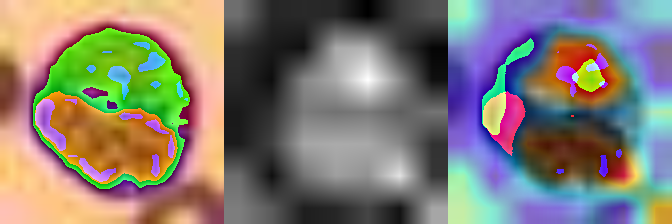

In [36]:
target_layers = [model.layer4]
with GradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

### GradCampPlusPlus

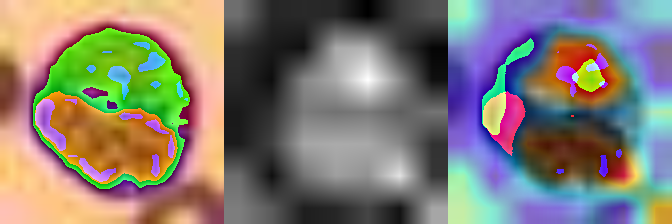

In [37]:
target_layers = [model.layer4]
with GradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

### EigenGradCAM

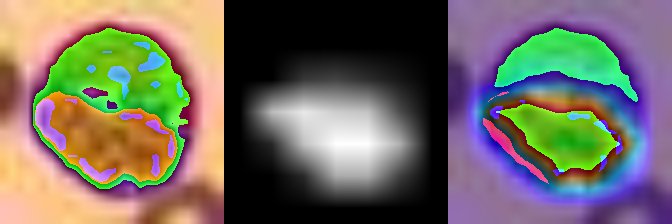

In [38]:
target_layers = [model.layer4]
with EigenGradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

### AblationCAM

100%|██████████| 64/64 [00:01<00:00, 36.31it/s]


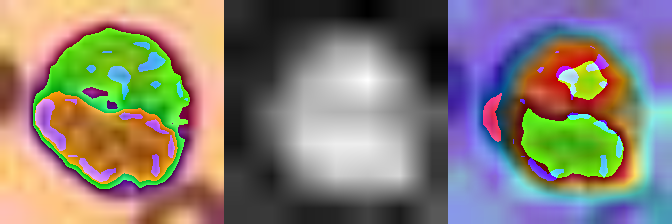

In [39]:
target_layers = [model.layer4]
with AblationCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

### RandomCAM

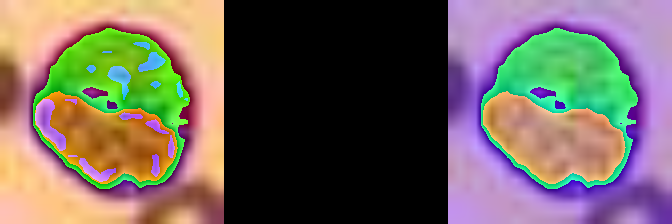

In [40]:
target_layers = [model.layer4]
with RandomCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.cuda(), targets=targets)
    cam_image = show_cam_on_image(image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(images)

# Actual Image

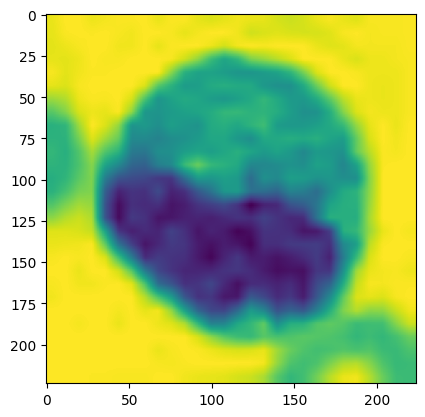

In [41]:
plt.imshow(input_tensor[0, 0, ...].numpy())

In [46]:
model, images, metrics = train('cuda', med_model, train_loader, 20, 0.001, input_tensor, targets, image)

100%|██████████| 75/75 [00:11<00:00,  6.55it/s]

100%|██████████| 10/10 [00:00<00:00, 14.65it/s][A


Grad-cam testing



  5%|▌         | 1/20 [00:16<05:10, 16.33s/it]

Train Epoch: 1 Loss: 0.381797 Validation loss: 0.330745 Acc: 87.677083 



100%|██████████| 75/75 [00:10<00:00,  7.35it/s]

100%|██████████| 10/10 [00:00<00:00, 14.08it/s]


Grad-cam testing



 10%|█         | 2/20 [00:29<04:25, 14.76s/it]

Train Epoch: 2 Loss: 3.303579 Validation loss: 1.842653 Acc: 22.795139 



100%|██████████| 75/75 [00:05<00:00, 13.17it/s]

100%|██████████| 10/10 [00:00<00:00, 15.57it/s][A


Grad-cam testing



 15%|█▌        | 3/20 [00:38<03:25, 12.08s/it]

Train Epoch: 3 Loss: 1.182074 Validation loss: 0.977491 Acc: 57.052083 



100%|██████████| 75/75 [00:09<00:00,  8.11it/s]

100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Grad-cam testing



 20%|██        | 4/20 [00:51<03:14, 12.19s/it]

Train Epoch: 4 Loss: 0.699298 Validation loss: 0.864057 Acc: 74.034722 



100%|██████████| 75/75 [00:09<00:00,  7.93it/s]

100%|██████████| 10/10 [00:00<00:00, 14.63it/s][A


Grad-cam testing



 25%|██▌       | 5/20 [01:03<03:03, 12.26s/it]

Train Epoch: 5 Loss: 0.511358 Validation loss: 0.414829 Acc: 79.871528 



100%|██████████| 75/75 [00:10<00:00,  7.30it/s]

100%|██████████| 10/10 [00:00<00:00, 15.82it/s][A


Grad-cam testing



 30%|███       | 6/20 [01:17<02:57, 12.66s/it]

Train Epoch: 6 Loss: 0.414281 Validation loss: 1.315051 Acc: 84.635417 



100%|██████████| 75/75 [00:05<00:00, 12.79it/s]

100%|██████████| 10/10 [00:00<00:00, 17.03it/s][A


Grad-cam testing



 35%|███▌      | 7/20 [01:25<02:27, 11.35s/it]

Train Epoch: 7 Loss: 0.353119 Validation loss: 0.319371 Acc: 87.024306 



100%|██████████| 75/75 [00:09<00:00,  7.63it/s]

100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


Grad-cam testing



 40%|████      | 8/20 [01:38<02:21, 11.81s/it]

Train Epoch: 8 Loss: 0.286628 Validation loss: 0.604287 Acc: 89.635417 



100%|██████████| 75/75 [00:09<00:00,  7.88it/s]

100%|██████████| 10/10 [00:00<00:00, 15.73it/s][A


Grad-cam testing



 45%|████▌     | 9/20 [01:51<02:12, 12.03s/it]

Train Epoch: 9 Loss: 0.253461 Validation loss: 0.290356 Acc: 90.961806 



100%|██████████| 75/75 [00:10<00:00,  7.38it/s]

100%|██████████| 10/10 [00:00<00:00, 15.21it/s][A


Grad-cam testing



 50%|█████     | 10/20 [02:04<02:03, 12.39s/it]

Train Epoch: 10 Loss: 0.251436 Validation loss: 0.354912 Acc: 90.979167 



100%|██████████| 75/75 [00:09<00:00,  7.74it/s]

100%|██████████| 10/10 [00:00<00:00, 14.74it/s]


Grad-cam testing



 55%|█████▌    | 11/20 [02:16<01:52, 12.47s/it]

Train Epoch: 11 Loss: 0.185570 Validation loss: 0.266692 Acc: 93.430556 



100%|██████████| 75/75 [00:09<00:00,  7.83it/s]

100%|██████████| 10/10 [00:00<00:00, 14.44it/s][A


Grad-cam testing



 60%|██████    | 12/20 [02:29<01:40, 12.51s/it]

Train Epoch: 12 Loss: 0.186517 Validation loss: 0.279974 Acc: 93.309028 



100%|██████████| 75/75 [00:10<00:00,  7.35it/s]

100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


Grad-cam testing



 65%|██████▌   | 13/20 [02:42<01:29, 12.75s/it]

Train Epoch: 13 Loss: 0.165176 Validation loss: 0.286736 Acc: 94.319444 



100%|██████████| 75/75 [00:09<00:00,  7.55it/s]

100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Grad-cam testing



 70%|███████   | 14/20 [02:55<01:17, 12.88s/it]

Train Epoch: 14 Loss: 0.133785 Validation loss: 0.295951 Acc: 95.472222 



100%|██████████| 75/75 [00:09<00:00,  7.83it/s]

100%|██████████| 10/10 [00:00<00:00, 16.30it/s][A


Grad-cam testing



 75%|███████▌  | 15/20 [03:08<01:04, 12.80s/it]

Train Epoch: 15 Loss: 0.108506 Validation loss: 0.323761 Acc: 96.302083 



100%|██████████| 75/75 [00:09<00:00,  7.74it/s]

100%|██████████| 10/10 [00:00<00:00, 16.27it/s][A


Grad-cam testing



 80%|████████  | 16/20 [03:21<00:50, 12.75s/it]

Train Epoch: 16 Loss: 0.147338 Validation loss: 0.296413 Acc: 95.072917 



100%|██████████| 75/75 [00:09<00:00,  7.67it/s]

100%|██████████| 10/10 [00:00<00:00, 13.94it/s]


Grad-cam testing



 85%|████████▌ | 17/20 [03:34<00:38, 12.83s/it]

Train Epoch: 17 Loss: 0.143136 Validation loss: 0.286735 Acc: 95.256944 



100%|██████████| 75/75 [00:09<00:00,  7.54it/s]

100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


Grad-cam testing



 90%|█████████ | 18/20 [03:47<00:25, 12.85s/it]

Train Epoch: 18 Loss: 0.080713 Validation loss: 0.353134 Acc: 97.135417 



100%|██████████| 75/75 [00:10<00:00,  7.34it/s]

100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Grad-cam testing



 95%|█████████▌| 19/20 [04:00<00:13, 13.02s/it]

Train Epoch: 19 Loss: 0.111848 Validation loss: 0.302060 Acc: 96.336806 



100%|██████████| 75/75 [00:09<00:00,  7.92it/s]

100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


Grad-cam testing



100%|██████████| 20/20 [04:13<00:00, 12.67s/it]

Train Epoch: 20 Loss: 0.061602 Validation loss: 0.332815 Acc: 97.666667 


<AxesSubplot: title={'center': 'Metrics'}>

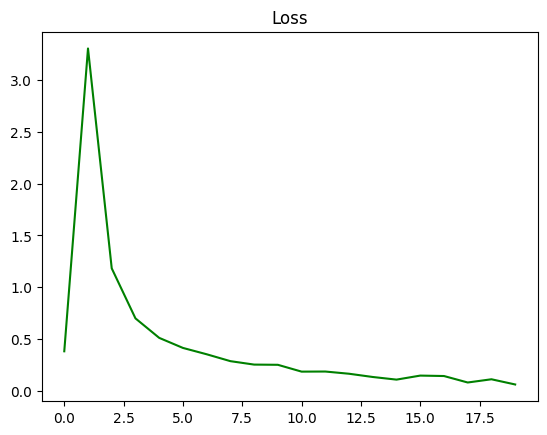

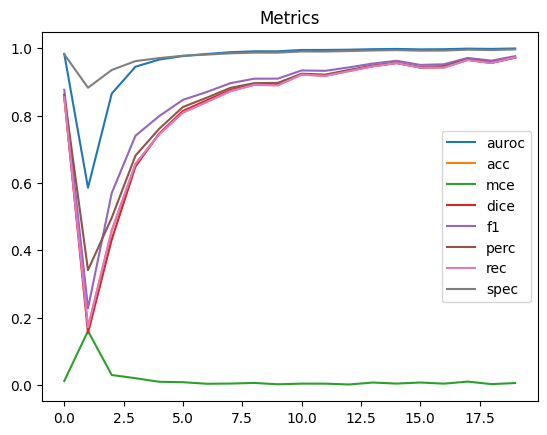

In [48]:
metric = pd.DataFrame.from_dict(metrics, orient = 'index', dtype='float32').T
loss = metric['loss']
metric = metric.drop(columns=['loss'])
loss.plot(title='Loss', color='green')
metric.plot(title='Metrics')

### GradCam

In [56]:
gd_cam_imgs_1 = np.hstack(images['gradcam'][:5])
gd_cam_imgs_2 = np.hstack(images['gradcam'][5:10])
gd_cam_imgs_3 = np.hstack(images['gradcam'][10:15])
gd_cam_imgs_4 = np.hstack(images['gradcam'][15:])

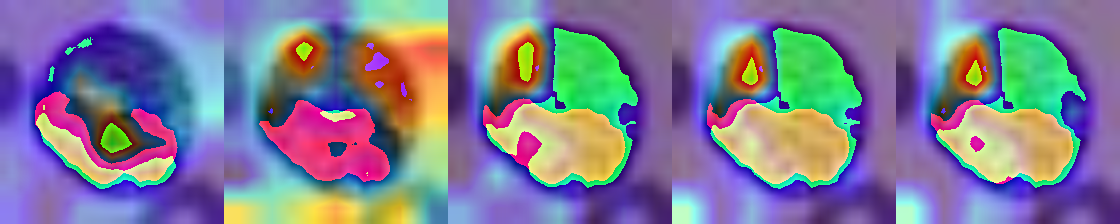

In [57]:
Image.fromarray(gd_cam_imgs_1)

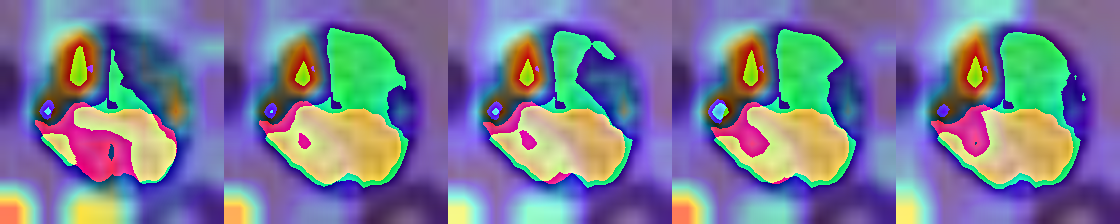

In [58]:
Image.fromarray(gd_cam_imgs_2)

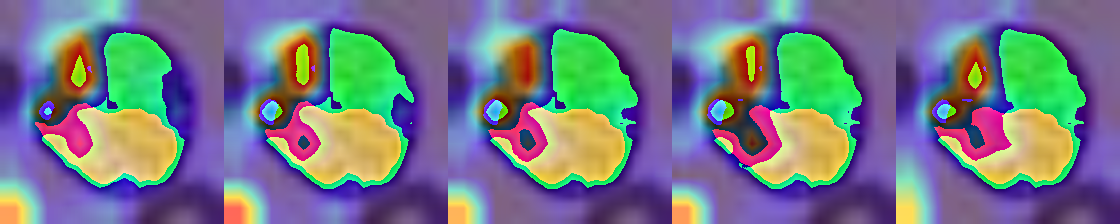

In [59]:
Image.fromarray(gd_cam_imgs_3)

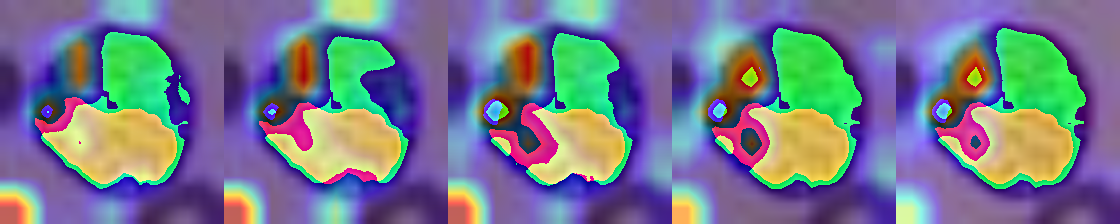

In [60]:
Image.fromarray(gd_cam_imgs_4)

------

### GradCamPlusPlus

In [69]:
gdpp_cam_imgs_1 = np.hstack(images['gradcamplusplus'][:5])
gdpp_cam_imgs_2 = np.hstack(images['gradcamplusplus'][5:10])
gdpp_cam_imgs_3 = np.hstack(images['gradcamplusplus'][10:15])
gdpp_cam_imgs_4 = np.hstack(images['gradcamplusplus'][15:])

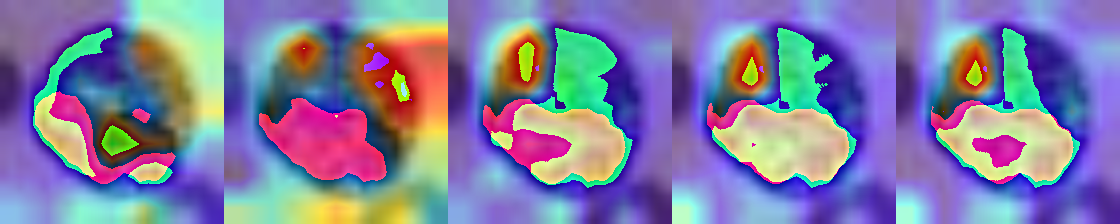

In [62]:
Image.fromarray(gdpp_cam_imgs_1)

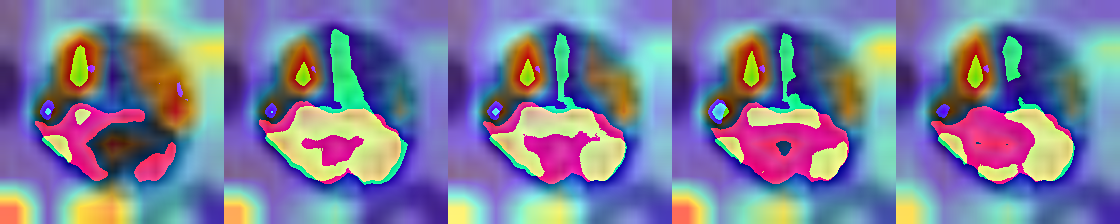

In [67]:
Image.fromarray(gdpp_cam_imgs_2)

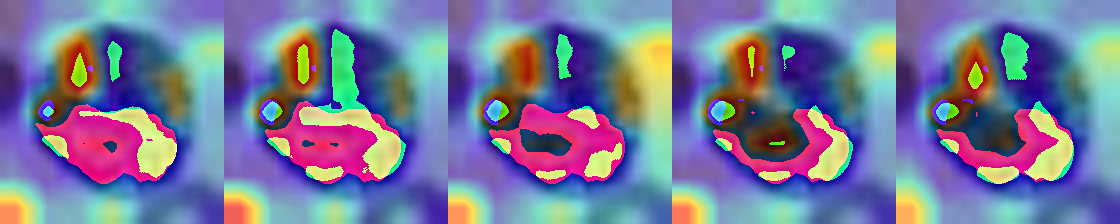

In [65]:
Image.fromarray(gdpp_cam_imgs_3)

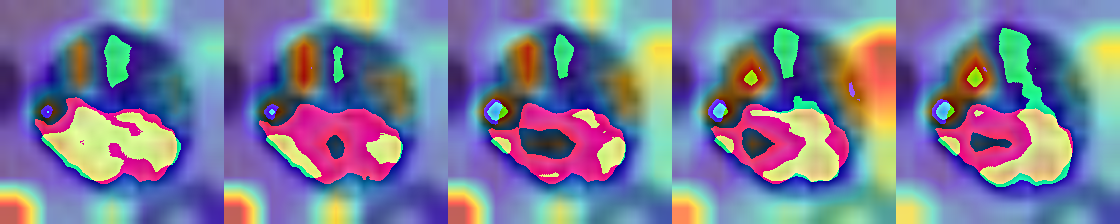

In [66]:
Image.fromarray(gdpp_cam_imgs_4)

-----

### EigenGradCAM

In [70]:
eig_cam_imgs_1 = np.hstack(images['EigenGradCAM'][:5])
eig_cam_imgs_2 = np.hstack(images['EigenGradCAM'][5:10])
eig_cam_imgs_3 = np.hstack(images['EigenGradCAM'][10:15])
eig_cam_imgs_4 = np.hstack(images['EigenGradCAM'][15:])

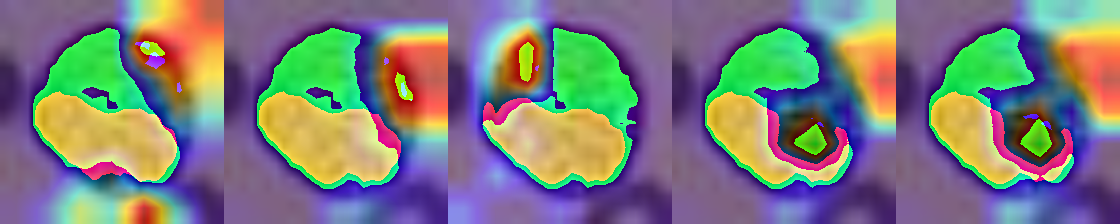

In [71]:
Image.fromarray(eig_cam_imgs_1)

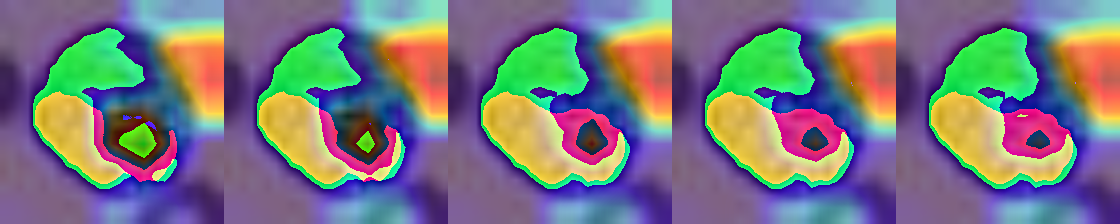

In [72]:
Image.fromarray(eig_cam_imgs_2)

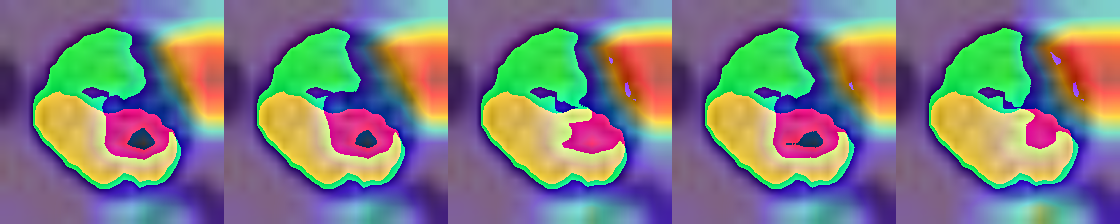

In [73]:
Image.fromarray(eig_cam_imgs_3)

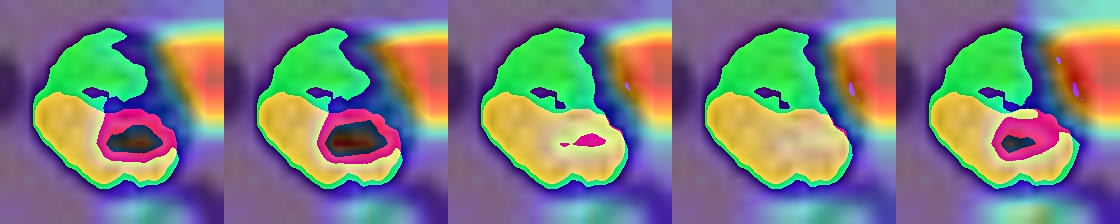

In [74]:
Image.fromarray(eig_cam_imgs_4)

In [75]:
ab_cam_imgs_1 = np.hstack(images['AblationCAM'][:5])
ab_cam_imgs_2 = np.hstack(images['AblationCAM'][5:10])
ab_cam_imgs_3 = np.hstack(images['AblationCAM'][10:15])
ab_cam_imgs_4 = np.hstack(images['AblationCAM'][15:])

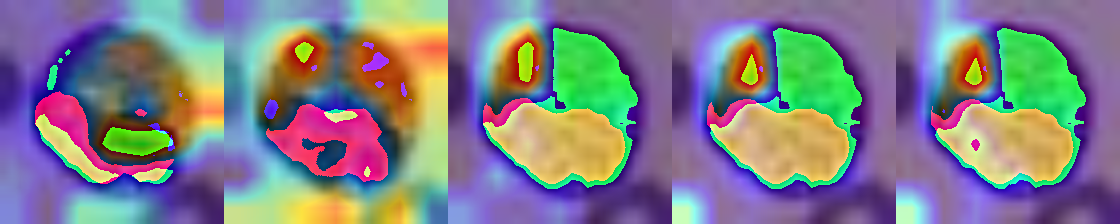

In [76]:
Image.fromarray(ab_cam_imgs_1)

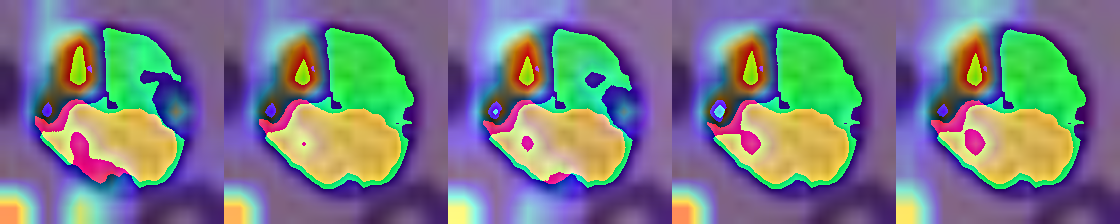

In [77]:
Image.fromarray(ab_cam_imgs_2)

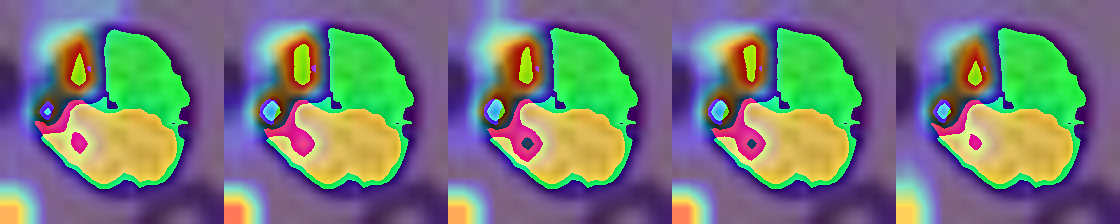

In [78]:
Image.fromarray(ab_cam_imgs_3)

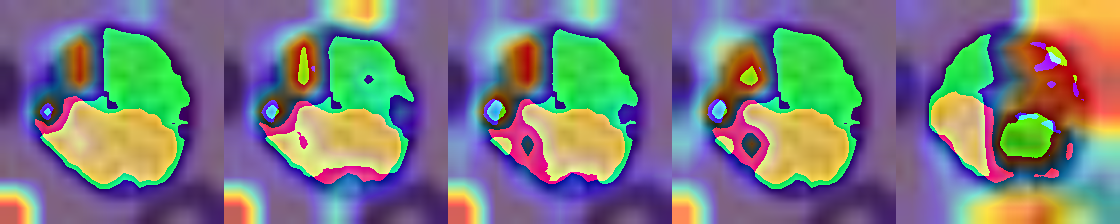

In [79]:
Image.fromarray(ab_cam_imgs_4)

-----

In [80]:
r_cam_imgs_1 = np.hstack(images['RandomCAM'][:5])
r_cam_imgs_2 = np.hstack(images['RandomCAM'][5:10])
r_cam_imgs_3 = np.hstack(images['RandomCAM'][10:15])
r_cam_imgs_4 = np.hstack(images['RandomCAM'][15:])

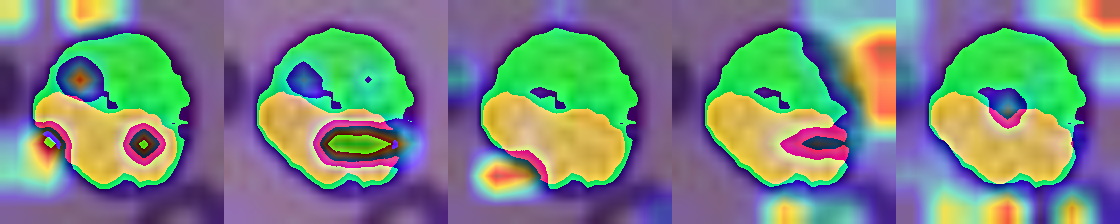

In [81]:
Image.fromarray(r_cam_imgs_1)

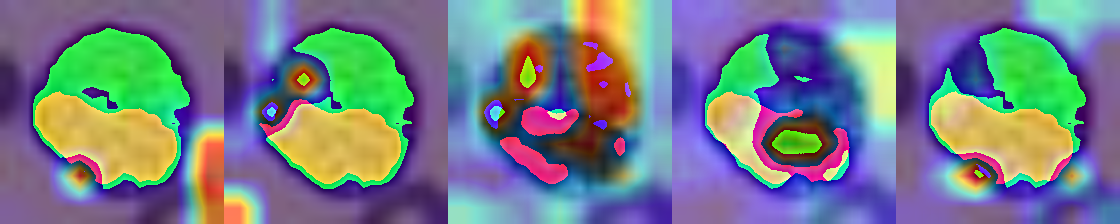

In [82]:
Image.fromarray(r_cam_imgs_2)

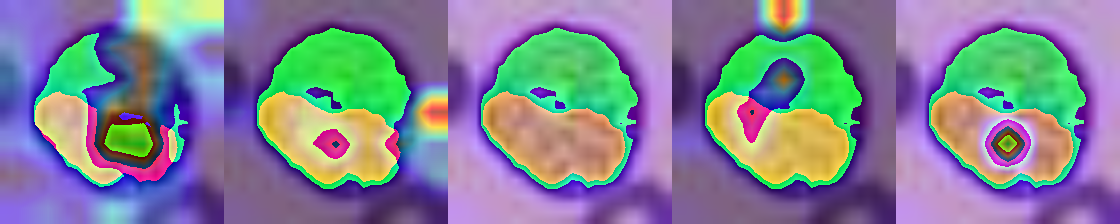

In [83]:
Image.fromarray(r_cam_imgs_3)

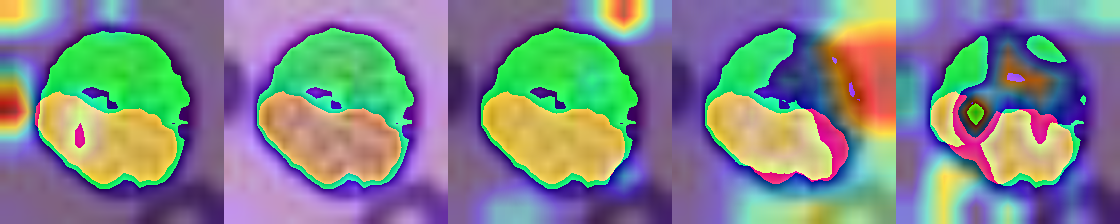

In [84]:
Image.fromarray(r_cam_imgs_4)

-----

## TEST

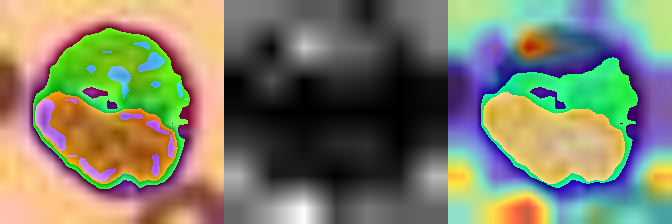

In [85]:
test_batch = list(iter(test_loader))[0]
test_batch_image, test_batch_targets = batch
test_image = test_batch_image[0]
test_target = test_batch_targets[0]
test_image = test_image.permute(2, 1, 0).numpy()
test_targets = [ClassifierOutputTarget(test_target)]
test_image = cv2.resize(test_image, (224, 224))
# test_image = np.float32(test_image) / 255

test_input_tensor = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
# targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model.to('cuda:0'), target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=test_input_tensor.cuda(), targets=test_targets)
    cam_image = show_cam_on_image(test_image, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
test_images = np.hstack((np.uint8(255*image), cam , cam_image))
Image.fromarray(test_images)

In [86]:
pred, images = test('cuda', model, test_loader, input_tensor=test_input_tensor, targets=test_targets, img=test_image)

Test-loop: 100%|██████████| 14/14 [00:01<00:00,  7.56it/s]


Test Accuracy: 92.078340
cam testing


100%|██████████| 64/64 [00:01<00:00, 37.10it/s]


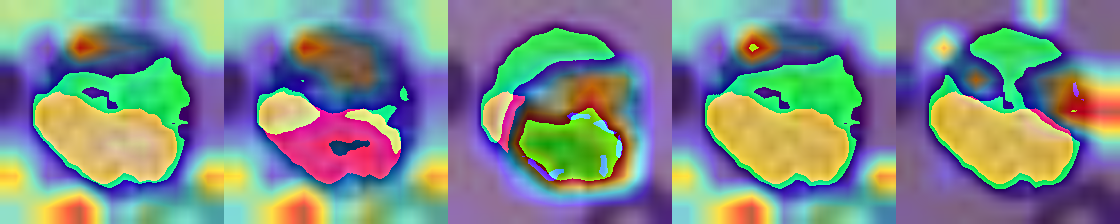

In [112]:
Image.fromarray(np.hstack(np.array(list(images.values())).squeeze(1)))

### ------Gradcam------------gradcamplusplus----------EigenGradCAM-----------AblationCAM-----------RandomCAM------

# Benchmarking

100%|██████████| 64/64 [00:01<00:00, 38.16it/s]


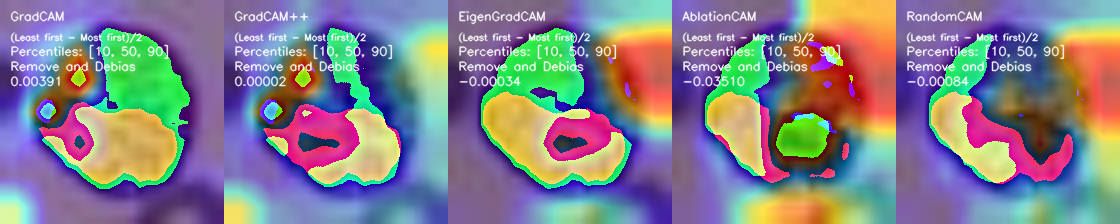

In [115]:
benchmark(input_tensor.cuda(), [model.layer4], image, eigen_smooth=False, aug_smooth=False, category=target)